Determining Heat Removal Requirements for Data

In [1]:
# Resets and clears all variables from kernel
%reset

In [2]:
import pandas as pd
import numpy as np

infile = "../sim_inputs_and_outputs/peakTorqueEnduranceResults.csv"

data = pd.read_csv(infile)

# CONSTANTS
num_parallel_cells = 5
thermal_resistance_in = 2.21714     # K/W
thermal_resistance_out = 10.6106    # K/W
single_cell_ir = 0.028              # Ohms
air_temp = 35                       # C
battery_heat_capacity = 35.098      # J/kgK

In [3]:
# Create list of dataDicts so that I can compare outputs amongst options
testData = []
maxTemps = []
totalEnergyOut = []
thermal_R_out_list = np.linspace(10.6106, 0.1, 10)  # Based on the literature (Bryden et al.), the result should be no less than this
thermal_R_out_list = np.insert(thermal_R_out_list, 0, 100000)    # Adding an adiabatic condition to the test set

# For requried input data (that does not change!)
dataDict = data[['r0', 't0', 'Cell Qgen', 'Cell Total Gen']].copy()
dataDict = dataDict.to_dict('list')
length = len(dataDict["t0"])

for thermal_R_out in thermal_R_out_list:

    # For new data:
    # Initialize dict for Battery Temp, Cell Qout, Cell Net Q, Cell Total Qout, Cell Net Heat
    tempDict = dict({'Battery Temp': np.zeros(length),
                     'Cell Qout': np.zeros(length),
                     'Cell Net Q': np.zeros(length),
                     'Cell Total Qout': np.zeros(length),
                     'Cell Net Heat': np.zeros(length)})
    # Only need to set 1 initial value:
    tempDict["Battery Temp"][0] = air_temp
    
    # Begin iteration:
    for i in range(0,length - 1):
        dt = dataDict['t0'][i+1] - dataDict['t0'][i]        # dt in units of seconds :)

        # NOTE TO SELF:
        # Look at my notes on confluence (https://ubcformulaelectric.atlassian.net/wiki/spaces/UFE/pages/edit-v2/405438472)
        # for how I came across this formula (and to verify that it is correct)
        air_temp_K = air_temp + 273.15      # Convert to K from C

        battery_temp_K = (((dataDict['Cell Qgen'][i] * thermal_R_out + air_temp_K) * dt
                        + (tempDict['Battery Temp'][i] + 273.15) * battery_heat_capacity * (thermal_resistance_in + thermal_R_out))
                        / (battery_heat_capacity * (thermal_resistance_in + thermal_R_out) + dt))

        tempDict['Battery Temp'][i+1] = battery_temp_K - 273.15     # Convert back to C from K

        # Calculate net heat generation rate (Qgen - Qtransferred)
        tempDict['Cell Qout'][i] = 1 / thermal_R_out * (tempDict['Battery Temp'][i] - air_temp)
        tempDict['Cell Net Q'][i] = dataDict['Cell Qgen'][i] - tempDict['Cell Qout'][i]

    # Add up heat removed from cells (J)
    if i != 0:
        # Now determine the energy parameters:
        dt = dataDict['t0'][i] - dataDict['t0'][i-1]

        thisOut = 1/2*(tempDict["Cell Qout"][i] + tempDict["Cell Qout"][i-1]) * dt
        tempDict["Cell Total Qout"][i+1] = tempDict["Cell Total Qout"][i] + thisOut

        # Add up net heat generated from cells (J)
        thisNet = 1/2*(tempDict["Cell Net Q"][i] + tempDict["Cell Net Q"][i-1]) * dt
        tempDict['Cell Net Heat'][i+1] = tempDict['Cell Net Heat'][i] + thisNet

    # Set special variables and saving of data
    maxCellTemperature = max(tempDict['Battery Temp'])

    lastElem = length - 1
    totalOutputEnergy = tempDict["Cell Total Qout"][lastElem]

    maxTemps.append(maxCellTemperature)
    totalEnergyOut.append(totalOutputEnergy)
    testData.append(tempDict)

maxTemps

[163.2328317860613,
 77.01144779958048,
 74.02710591665334,
 70.86132658583176,
 67.41617003568467,
 63.51074883794212,
 59.30717703535089,
 54.50142732183889,
 49.16452376532811,
 42.93879503817021,
 35.68618943081839]

Now let's plot the outputs on top of each other

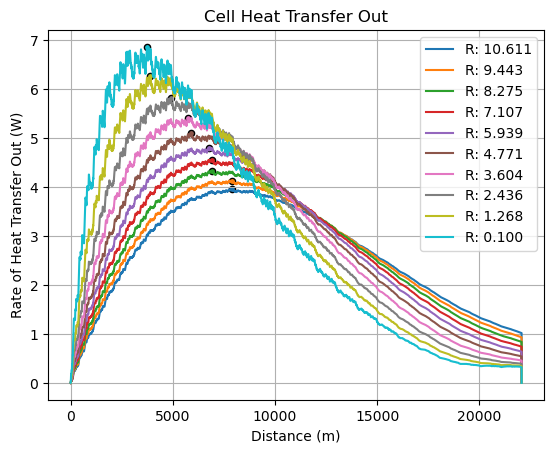

In [4]:
import matplotlib.pyplot as plt

for outputData, thermal_R in zip(testData, thermal_R_out_list):
    
    if thermal_R < 100:
        name = ('R: %.3f' % thermal_R) 
        plt.plot(dataDict["r0"], outputData["Cell Qout"], label=name)

        maxOut = max(outputData["Cell Qout"])
        maxOutIndex = list(outputData["Cell Qout"]).index(maxOut)
        maxOutTime = dataDict["r0"][maxOutIndex]
        plt.scatter(maxOutTime, maxOut, s=20, marker='o', edgecolors='k')

plt.title("Cell Heat Transfer Out")
plt.xlabel("Distance (m)")
plt.ylabel("Rate of Heat Transfer Out (W)")
plt.legend()
plt.grid(True)
plt.savefig("Heat_Transfer_Out_vary_Therm_R.png")
plt.show()

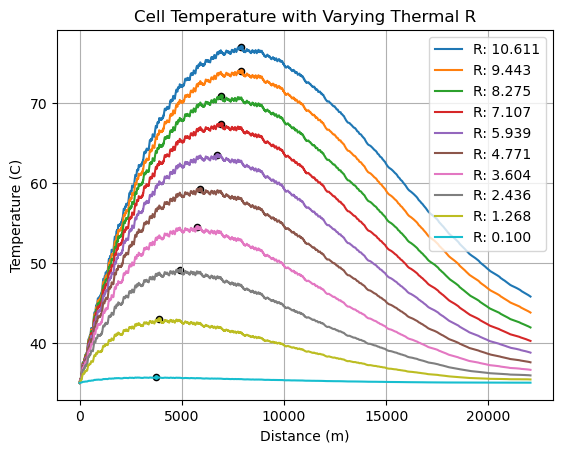

In [5]:
import matplotlib.pyplot as plt

for outputData, thermal_R, maxTemp in zip(testData, thermal_R_out_list, maxTemps):
    if thermal_R > 100:
        name = "Adiabatic Case"
    else:
        name = ('R: %.3f' % thermal_R)

        plt.plot(dataDict["r0"], outputData["Battery Temp"], label=name)

        maxTempIndex = list(outputData["Battery Temp"]).index(maxTemp)
        maxTempTime = dataDict["r0"][maxTempIndex]
        plt.scatter(maxTempTime, maxTemp, s=20, marker='o', edgecolors='k')

plt.title("Cell Temperature with Varying Thermal R")
plt.xlabel("Distance (m)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid(True)
plt.savefig("Cell_Temp_Vary_Therm_R.png")
plt.show()

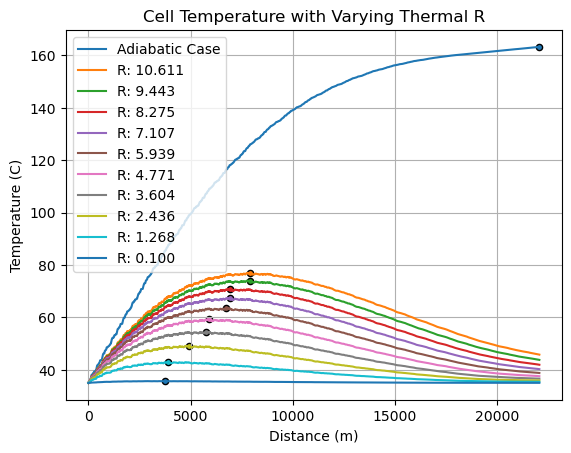

In [6]:
import matplotlib.pyplot as plt

for outputData, thermal_R, maxTemp in zip(testData, thermal_R_out_list, maxTemps):
    if thermal_R > 100:
        name = "Adiabatic Case"
    else:
        name = ('R: %.3f' % thermal_R)

    plt.plot(dataDict["r0"], outputData["Battery Temp"], label=name)

    maxTempIndex = list(outputData["Battery Temp"]).index(maxTemp)
    maxTempTime = dataDict["r0"][maxTempIndex]
    plt.scatter(maxTempTime, maxTemp, s=20, marker='o', edgecolors='k')

plt.title("Cell Temperature with Varying Thermal R")
plt.xlabel("Distance (m)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid(True)
plt.savefig("Cell_Temp_Vary_Therm_R_adiabatic.png")
plt.show()

So this tells us that we need an outward thermal resistance of less than 5.9 K/W. When I look at the averages of each of the options, there is not much difference, so the thermal resistance coefficient is likely more important for this modelling.

What does this correspond to for heat transfer coefficient?

In [10]:
from math import pi
cylinder_area = lambda r, h: 2*pi*r*h + 2*pi*r**2

area_18650 = cylinder_area(18, 65) / 1000**2
area_26650 = cylinder_area(26, 65) / 1000**2

# Corresponding output based on paper results:
possible_Rs = thermal_R_out_list[thermal_R_out_list < 5]

# Resulting values for 26650 to compare with paper
scaled_to_26 = np.array(possible_Rs) * area_18650 / area_26650

# Note that values below 1.6 K/W are likely not possible, considering the results of the study
print(scaled_to_26)

# What this means to me is that we should be able to get reasonable heat removal from an air-cooled system

# Resulting heat transfer coefficient: R = 1/(hA) -therefore- h = 1/RA
htc = 1 / (area_18650 * np.array(possible_Rs))

# If we only consider cooling from the bottom, then we'll see the following:
bottom_area_18650 = (pi * 18**2) / 1000**2
htc_axial = 1 / (bottom_area_18650 * np.array(possible_Rs))
htc_axial

[3.01286492 2.27543483 1.53800473 0.80057464 0.06314455]


array([ 102.95117742,  136.3159196 ,  201.67557622,  387.44418711,
       4912.1896016 ])